In [2]:
import sys
sys.path.insert(1,'/home/kwu/anaconda3/lib/python3.6/site-packages')
import pytraj as pt
from sklearn.cluster import KMeans
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In /home/kwu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kwu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kwu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kwu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kwu/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [25]:
DIR = '/hdd/kingsley/GPU0_DATA/1Z0Q/14sb3/'
TRAJ='/hdd/kingsley/GPU0_DATA/1Z0Q/14sb3/1us_14sb.dcd'
TOP='/hdd/kingsley/GPU0_DATA/1Z0Q/14sb3/14sb_3.prmtop'

### Load Trajectory

In [1]:
traj = pt.iterload(TRAJ,TOP)
frameidx=np.array(range(traj.n_frames))
traj

NameError: name 'pt' is not defined

#### superimpose the trajectory to the refertence frame

In [27]:
pt.superpose(traj, ref=0, mask='@CA')

pytraj.TrajectoryIterator, 10000 frames: 
Size: 0.140145 (GB)
<Topology: 627 atoms, 42 residues, 1 mols, non-PBC>
           

### Cluster by Dihedral Angles

#### Compute phi and psi from the trajectory (this will take a while)

In [28]:
PhiPsi=[]
for i in range(1,traj.top.n_residues):
    tmp = pt.dihedral(traj['(:%d,%d)&(@CA,C,N)'%(i,i+1)],[[0,1,2,3],[2,3,4,5]]).T
    PhiPsi.append(tmp)
PhiPsi = np.concatenate(PhiPsi,axis=1)

In [29]:
PhiPsi.shape

(10000, 82)

#### for each dihedral, compute sin($\theta$) and cos($\theta$)

In [30]:
data = PhiPsi[:].copy()
data = np.concatenate([np.sin(data/360*2*np.pi),np.cos(data/360*2*np.pi)],axis=1)
data.shape

(10000, 164)

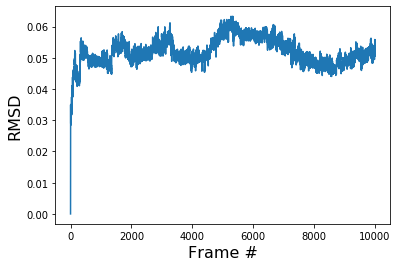

In [31]:
RMSD_data = np.linalg.norm(data - data[0,:], axis=1)/data.shape[1]

fig=plt.figure()
plt.plot(range(len(RMSD_data)), RMSD_data)
plt.xlabel('Frame #', fontsize = 16)
plt.ylabel('RMSD', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_dihedral.pdf')

#### Optimize k using an elbow curve

In [32]:
Kdistant=[]
n_datas = len(RMSD_data)
for k in range(1,100):
    tmp=0
    kmeans = KMeans(n_clusters=k, init='k-means++').fit(RMSD_data.reshape(-1,1))
    labels = kmeans.predict(RMSD_data.reshape(-1,1))
    C = kmeans.cluster_centers_
    

    tmp+=np.linalg.norm(RMSD_data.reshape(-1,1)[labels==(k-1)] - C[(k-1)], axis=1).sum()
    Kdistant.append([k,tmp/n_datas])
Kdistant=np.array(Kdistant)

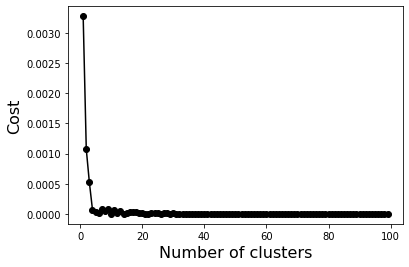

In [33]:
fig=plt.figure()
plt.plot(Kdistant[:,0],Kdistant[:,1], marker='o', color='k')
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()
fig.savefig(DIR+'/Elbow_curve_dihedral.pdf')

In [34]:
nc=80 # change the optimized number of clusters here according to the elbow curve
kmeans = KMeans(n_clusters=nc, init='k-means++').fit(data)
labels = kmeans.predict(data)
C = kmeans.cluster_centers_

#### Color each cluster

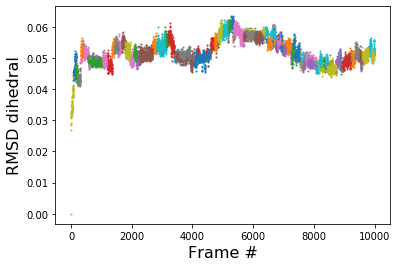

In [35]:
RMSD_data = np.linalg.norm(data - data[0,:], axis=1)/data.shape[1]

fig=plt.figure()
for i in range(len(C)):
    plt.scatter(np.array(range(len(RMSD_data)))[labels==i], RMSD_data[labels==i], s=1)
plt.xlabel('Frame #', fontsize = 16)
plt.ylabel('RMSD dihedral', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_dihedral_colored.pdf')

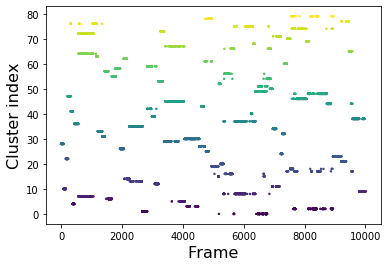

In [36]:
fig=plt.figure()
plt.scatter(range(len(data)), labels, c= labels, s = 2)
plt.xlabel('Frame', fontsize = 16)
plt.ylabel('Cluster index', fontsize = 16)
plt.show()
fig.savefig(DIR+'/RMSD_dihedral_cluster_index.pdf')

#### Export separate trajectories of clusters

In [37]:
Out = DIR+'RMSD_dihedral' # make sure you've created this ooutput folder in your computer

In [38]:
for i in range(nc):
    traj[frameidx[labels==i].tolist()].save(Out+'/rmsd_dihedral_%d.dcd'%(i+1), overwrite=True)
    print("cluster %d"%(i+1), "%d frames"%len(frameidx[labels==i]))

cluster 1 138 frames
cluster 2 155 frames
cluster 3 265 frames
cluster 4 109 frames
cluster 5 55 frames
cluster 6 117 frames
cluster 7 127 frames
cluster 8 148 frames
cluster 9 219 frames
cluster 10 153 frames
cluster 11 81 frames
cluster 12 93 frames
cluster 13 117 frames
cluster 14 43 frames
cluster 15 94 frames
cluster 16 42 frames
cluster 17 87 frames
cluster 18 167 frames
cluster 19 90 frames
cluster 20 213 frames
cluster 21 101 frames
cluster 22 152 frames
cluster 23 60 frames
cluster 24 269 frames
cluster 25 47 frames
cluster 26 69 frames
cluster 27 125 frames
cluster 28 107 frames
cluster 29 79 frames
cluster 30 156 frames
cluster 31 372 frames
cluster 32 83 frames
cluster 33 79 frames
cluster 34 142 frames
cluster 35 102 frames
cluster 36 384 frames
cluster 37 127 frames
cluster 38 227 frames
cluster 39 271 frames
cluster 40 95 frames
cluster 41 32 frames
cluster 42 61 frames
cluster 43 32 frames
cluster 44 79 frames
cluster 45 149 frames
cluster 46 271 frames
cluster 47 248 f

In [39]:
Out

'/hdd/kingsley/GPU0_DATA/1Z0Q/14sb3/RMSD_dihedral'